#### Import Library

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import math
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import skimage.io as io
import glob
from skimage.transform import resize
from skimage.color import rgb2gray
from keras.callbacks import ModelCheckpoint
from PIL import Image
from skimage.transform import resize
import numpy as np 
from keras.optimizers import *
from keras.models import *
from keras.layers import *
from tqdm import tqdm
from google.colab import drive
import tensorflow as tf
from keras.layers import Input
import random

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


#### Load Data

##### Open Google Drive

In [2]:
drive.mount('/content/gdrive', force_remount=True)
root_dir =  "/content/gdrive/My Drive/Colab Notebooks/CSE676/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


##### Get all the file path from dataset

In [0]:
image_path,mask_path=[],[]
main_path =  "/content/gdrive/My Drive/Colab Notebooks/CSE676/Dataset/"

folders=os.listdir(main_path)
folders.remove('data.csv')
folders.remove('README.md')
folders.remove(".DS_Store")
for i in folders:
  next_folder = os.path.join(main_path,i)  
  # print(os.listdir(next_folder),len(os.listdir(next_folder)))
  for file in os.listdir(next_folder):
    if "mask" in file:
      mask_path.append(os.path.join(next_folder,file))
    elif "DS_Store" in file:
      continue
    else:
      image_path.append(os.path.join(next_folder,file))

##### Order the image_path and mask_path that in the same index is represent same picture



In [6]:
img_wm=[]
random.shuffle(image_path)

for img_p in tqdm(image_path):
    img_p=img_p.split('.')
    img_p[0]=img_p[0]+'_mask'
    img_p='.'.join(img_p)
    if img_p not in mask_path:
        img_wm.append(img_p)
if len(img_wm)==0:
    print('All the images have masks')

del mask_path
mask_path=[]
for img_p in tqdm(image_path): 
    img_p=img_p.split('.')
    img_p[0]=img_p[0]+'_mask'
    img_p='.'.join(img_p)
    mask_path.append(img_p)

100%|██████████| 3929/3929 [00:00<00:00, 857231.61it/s]

All the images have masks


##### Check the image we load from dataset

/content/gdrive/My Drive/Colab Notebooks/CSE676/Dataset/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_35.tif


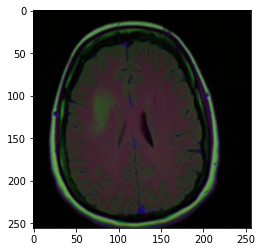

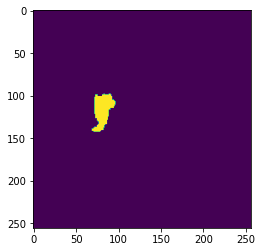

0.16470588235294117


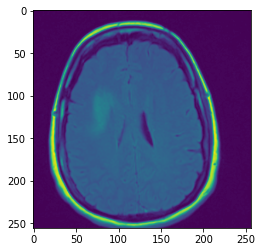

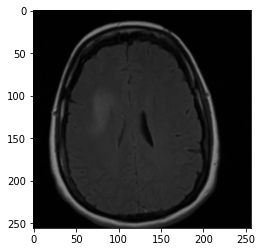

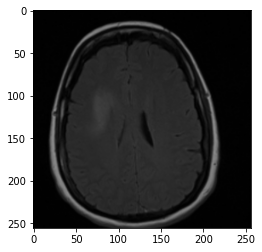

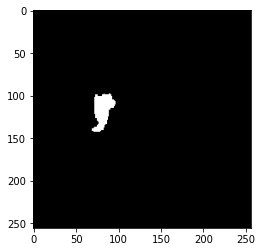

In [7]:
print(image_path[5])
img = plt.imread(image_path[5])
plt.imshow(img)
plt.show()

mask = plt.imread(mask_path[5])
plt.imshow(mask)
plt.show()
# print(mask)

image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

z = image.astype(np.float)
z = z/255

print(z[100][100])
plt.imshow(z)
plt.show()

plt.imshow(np.dstack((z,z,z)))
plt.show()

plt.imshow(np.dstack((image,image,image)))
plt.show()

plt.imshow(np.dstack((mask,mask,mask)))
plt.show()

##### Read all the data as GREY Image

In [11]:
images, masks = [],[]

count = 0
for path in image_path:
  count+= 1
  if(count % 500 == 0):
    print(count)
  a = plt.imread(path)
  a = (cv2.cvtColor(a, cv2.COLOR_BGR2GRAY))
  images.append(a)

for path in mask_path:
  b = plt.imread(path)
  b = b/255
  masks.append(b)

500
1000
1500
2000
2500
3000
3500


##### Reshape the data into (len(data),256,256,channel)

In [0]:
X_train = np.zeros((len(images),256,256, 1), dtype=np.uint8)
Y_train = np.zeros((len(masks), 256, 256, 1), dtype=np.uint8)

for i in range(len(images)):
  k  = images[i]
  k = np.reshape(k, (256, 256,1))
  X_train[i] = k

for j in range(len(masks)):
  k  = masks[j]
  k = np.reshape(k, (256, 256,1))
  Y_train[j] = k

# print(masks[6][100])

##### Calculate Accuracy

In [0]:
def miou(masks,predis_tran_t):
  total = 0
  for i in range(len(masks)):
    p_num = 0
    n_num = 0
    p_correct = 0
    n_correct = 0
    for x in range(0,len(masks[i])):
      for j in range(0,len(masks[i][x])):
        if(masks[i][x][j]!=0):
          p_num += 1
          if(preds_train_t[i][x][j]!=0):
            p_correct +=1
        else:
          n_num += 1
          if(preds_train_t[i][x][j]==0):
            n_correct += 1
    if(p_num ==0):
      total += n_correct/n_num
    else:
      total += ((p_correct/p_num +  n_correct/n_num)/2)
  # print(total/len(masks))
  return total/len(masks)

In [8]:
img_wm=[]
random.shuffle(image_path)

for img_p in tqdm(image_path):
    img_p=img_p.split('.')
    img_p[0]=img_p[0]+'_mask'
    img_p='.'.join(img_p)
    if img_p not in mask_path:
        img_wm.append(img_p)
if len(img_wm)==0:
    print('All the images have masks')

del mask_path
mask_path=[]
for img_p in tqdm(image_path): 
    img_p=img_p.split('.')
    img_p[0]=img_p[0]+'_mask'
    img_p='.'.join(img_p)
    mask_path.append(img_p)

images, masks = [],[]

count = 0
for path in image_path:
  count+= 1
  if(count % 500 == 0):
    print(count)
  a = plt.imread(path)
  a = (cv2.cvtColor(a, cv2.COLOR_BGR2GRAY))
  images.append(a)

for path in mask_path:
  b = plt.imread(path)
  b = b
  masks.append(b)

X_train = np.zeros((3300, 256,256, 1), dtype=np.float)
Y_train = np.zeros((3300, 256, 256, 1), dtype=np.float)

X_test = np.zeros((629,256,256, 1), dtype=np.float)
# X_train = np.zeros((3300, 256,256, 1), dtype=np.uint8)
# Y_train = np.zeros((3300, 256, 256, 1), dtype=np.uint8)

# X_test = np.zeros((629,256,256, 1), dtype=np.uint8)
for i in range(len(images)):
  if(i<3300):
    k  = images[i]/255
    # k  = images[i]
    k = np.reshape(k, (256, 256,1))
    X_train[i] = k
  else:
    k  = images[i]
    k  = images[i]/255
    k = np.reshape(k, (256, 256,1))
    X_test[i-3300] = k

for j in range(0,3300):
  k  = masks[j]/255
  # k  = masks[j]
  k = np.reshape(k, (256, 256,1))
  Y_train[j] = k

100%|██████████| 3929/3929 [00:00<00:00, 929622.63it/s]


All the images have masks
500
1000
1500
2000
2500
3000
3500


##### Data Generator

In [0]:
def get_augmented(
    X_train,
    Y_train,
    X_val=None,
    Y_val=None,
    batch_size=32,
    seed=0,
    data_gen_args=dict(
        rotation_range=10.0,
        # width_shift_range=0.02,
        height_shift_range=0.02,
        shear_range=5,
        # zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode="constant",
    ),
):

    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(
        X_train, batch_size=batch_size, shuffle=True, seed=seed
    )
    Y_train_augmented = Y_datagen.flow(
        Y_train, batch_size=batch_size, shuffle=True, seed=seed
    )

    train_generator = zip(X_train_augmented, Y_train_augmented)

    if not (X_val is None) and not (Y_val is None):
        # Validation data, no data augmentation, but we create a generator anyway
        X_datagen_val = ImageDataGenerator(**data_gen_args)
        Y_datagen_val = ImageDataGenerator(**data_gen_args)
        X_datagen_val.fit(X_val, augment=True, seed=seed)
        Y_datagen_val.fit(Y_val, augment=True, seed=seed)
        X_val_augmented = X_datagen_val.flow(
            X_val, batch_size=batch_size, shuffle=True, seed=seed
        )
        Y_val_augmented = Y_datagen_val.flow(
            Y_val, batch_size=batch_size, shuffle=True, seed=seed
        )

        # combine generators into one which yields image and masks
        val_generator = zip(X_val_augmented, Y_val_augmented)

        return train_generator, val_generator
    else:
        return train_generator

#### Build Model

##### First Model by using dsc loss with maxpooling

###### Model

In [0]:
img_size = 256

# learning rate

smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum((y_true),-1) + K.sum((y_pred),-1) - intersection + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def first_model():
  start_neurons=16
  inputs = Input((256, 256,1))
  # s = Lambda(lambda x: x / 255) (inputs)

  # standard size 128 -> 64   custome size 101 -> 50
  conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(inputs)
  conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
  pool1 = MaxPooling2D((2, 2))(conv1)
  #pool1 = Dropout(0.25)(pool1)

  # standard size 64 -> 32       custome size 50 -> 25
  conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
  conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
  pool2 = MaxPooling2D((2, 2))(conv2)
  #pool2 = Dropout(0.25)(pool2)

  # standard size 32 -> 16       custome size 25 -> 12
  conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
  conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
  pool3 = MaxPooling2D((2, 2))(conv3)
  #pool3 = Dropout(0.25)(pool3)

  # standard size 16 -> 8       custome size 12 -> 6
  conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
  conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
  pool4 = MaxPooling2D((2, 2))(conv4)
  #pool4 = Dropout(0.25)(pool4)

  # Middle
  convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
  convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

  # standard size 8 -> 16         custome size 6-> 12
  deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
  uconv4 = concatenate([deconv4, conv4])
  #uconv4 = Dropout(0.25)(uconv4)
  uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
  uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

  # standard size 16 -> 32        custome size 12 -> 25
  # Changed padding from "same" to "valid" to round up image to next size
  #deconv3a = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
  deconv3 = Conv2DTranspose(start_neurons * 4, (2, 2), strides=(2, 2), padding="same")(uconv4)
  uconv3 = concatenate([deconv3, conv3])
  #uconv3 = Dropout(0.25)(uconv3)
  uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
  uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

  # standard size 32 -> 64   custome size 25 -> 50
  deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
  uconv2 = concatenate([deconv2, conv2])
  #uconv2 = Dropout(0.25)(uconv2)
  uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
  uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

  # standard size 64 -> 128   custome size 50 -> 101
  # Changed padding from "same" to "valid" to round up image to next size
  #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
  deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
  uconv1 = concatenate([deconv1, conv1])
  #uconv1 = Dropout(0.25)(uconv1)
  uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
  uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

  #uconv1 = Dropout(0.25)(uconv1)
  output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
  model = Model(inputs=[inputs], outputs=[output_layer])
  model.compile(optimizer=Adam(lr=1e-7), loss=dice_coef_loss, metrics=[dice_coef])
  model.summary()
  return model

###### Training

In [25]:
from keras.callbacks import EarlyStopping
train_generator = get_augmented(X_train,Y_train)

model1 = first_model()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('cse676_1.h5', verbose=1, save_best_only=True)
r1 = model1.fit_generator(train_generator,steps_per_epoch=100,epochs=50,callbacks=[earlystopper, checkpointer])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_39[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_40[0][0]                  
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,dice_coef
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


100/100 [==============================] - 24s 235ms/step - loss: 0.3296 - dice_coef: 0.6704
Epoch 3/50
100/100 [==============================] - 24s 239ms/step - loss: 0.3295 - dice_coef: 0.6705
Epoch 4/50
100/100 [==============================] - 23s 235ms/step - loss: 0.3296 - dice_coef: 0.6704
Epoch 5/50
100/100 [==============================] - 24s 235ms/step - loss: 0.3294 - dice_coef: 0.6706
Epoch 6/50
100/100 [==============================] - 23s 234ms/step - loss: 0.3296 - dice_coef: 0.6704
Epoch 7/50
100/100 [==============================] - 23s 235ms/step - loss: 0.3294 - dice_coef: 0.6707
Epoch 8/50
100/100 [==============================] - 24s 235ms/step - loss: 0.3295 - dice_coef: 0.6705
Epoch 9/50
100/100 [==============================] - 24s 237ms/step - loss: 0.3294 - dice_coef: 0.6706
Epoch 10/50
100/100 [==============================] - 23s 234ms/step - loss: 0.3294 - dice_coef: 0.6706
Epoch 11/50
100/100 [==============================] - 24s 236ms/step - lo

###### Result Predict Graph

629/629 [==============================] - 1s 2ms/step


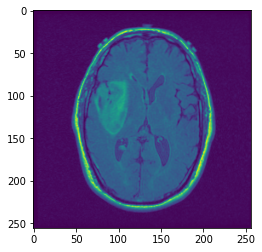

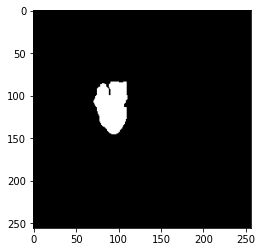

0.49616352


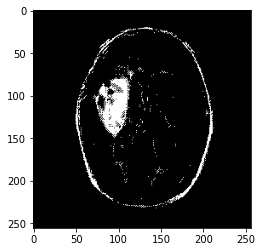

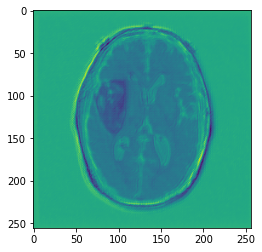

[0]


In [67]:
preds_train = model1.predict(X_test[:int(X_train.shape[0]*0.9)], verbose=1)
# preds_train_t = (preds_train <0.23
# ).astype(np.uint8)
preds_train_t = (preds_train <0.488
).astype(np.uint8)
# idx = 130
idx = 210


plt.imshow(images[3300+idx])
plt.show()

tmp2 = masks[3300+idx]
plt.imshow(np.dstack((tmp2,tmp2,tmp2)))
plt.show()

print(np.mean(preds_train))
tmp = np.squeeze(preds_train_t[idx]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
# np.mean(preds_train[idx])
tmp3 = preds_train[idx]
# print(np.mean(tmp3))
# plt.imshow(np.dstack((tmp3,tmp3,tmp3)))
plt.imshow(tmp3.reshape(256,256))
plt.show()
print(preds_train_t[210][100][125])

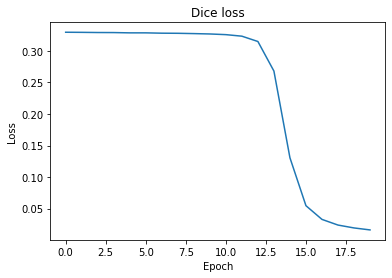

In [22]:
plt.plot(r1.history['loss'])
plt.title('Dice loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [69]:
print(miou(masks[3300:len(masks)],preds_train_t))

0.8525576516117239


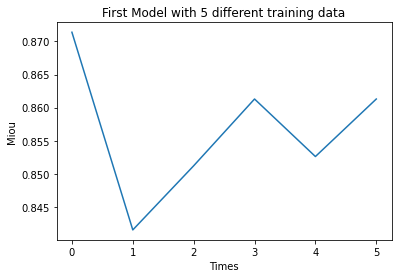

In [76]:
l = [0.8714,0.8415,0.8512,0.8613,0.8526,0.8613]

plt.plot(l)
plt.title('First Model with 5 different training data')
plt.ylabel('Miou')
plt.xlabel('Times')
plt.show()

##### Second Model by using binary_crossentropy loss

###### Model

In [0]:
def second_model():
  start_neurons=16
  inputs = Input((256, 256,1))
  # s = Lambda(lambda x: x / 255) (inputs)

  # standard size 128 -> 64   custome size 101 -> 50
  conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(inputs)
  conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
  pool1 = MaxPooling2D((2, 2))(conv1)
  #pool1 = Dropout(0.25)(pool1)

  # standard size 64 -> 32       custome size 50 -> 25
  conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
  conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
  pool2 = MaxPooling2D((2, 2))(conv2)
  #pool2 = Dropout(0.25)(pool2)

  # standard size 32 -> 16       custome size 25 -> 12
  conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
  conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
  pool3 = MaxPooling2D((2, 2))(conv3)
  #pool3 = Dropout(0.25)(pool3)

  # standard size 16 -> 8       custome size 12 -> 6
  conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
  conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
  pool4 = MaxPooling2D((2, 2))(conv4)
  #pool4 = Dropout(0.25)(pool4)

  # Middle
  convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
  convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

  # standard size 8 -> 16         custome size 6-> 12
  deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
  uconv4 = concatenate([deconv4, conv4])
  #uconv4 = Dropout(0.25)(uconv4)
  uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
  uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

  # standard size 16 -> 32        custome size 12 -> 25
  # Changed padding from "same" to "valid" to round up image to next size
  #deconv3a = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
  deconv3 = Conv2DTranspose(start_neurons * 4, (2, 2), strides=(2, 2), padding="same")(uconv4)
  uconv3 = concatenate([deconv3, conv3])
  #uconv3 = Dropout(0.25)(uconv3)
  uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
  uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

  # standard size 32 -> 64   custome size 25 -> 50
  deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
  uconv2 = concatenate([deconv2, conv2])
  #uconv2 = Dropout(0.25)(uconv2)
  uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
  uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

  # standard size 64 -> 128   custome size 50 -> 101
  # Changed padding from "same" to "valid" to round up image to next size
  #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
  deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
  uconv1 = concatenate([deconv1, conv1])
  #uconv1 = Dropout(0.25)(uconv1)
  uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
  uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

  #uconv1 = Dropout(0.25)(uconv1)
  output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
  model = Model(inputs=[inputs], outputs=[output_layer])
  model.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=['accuracy'])
  model.summary()
  return model

###### Training

In [27]:
from keras.callbacks import EarlyStopping
train_generator = get_augmented(X_train,Y_train)

model2 = second_model()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('cse676_2.h5', verbose=1, save_best_only=True)
r2 = model2.fit_generator(train_generator,steps_per_epoch=100,epochs=20,callbacks=[earlystopper, checkpointer])

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 256, 256, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 128, 128, 16) 0           conv2d_59[0][0]                  
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


100/100 [==============================] - 24s 241ms/step - loss: 0.0425 - accuracy: 0.9889
Epoch 3/20
100/100 [==============================] - 24s 239ms/step - loss: 0.0382 - accuracy: 0.9887
Epoch 4/20
100/100 [==============================] - 24s 242ms/step - loss: 0.0361 - accuracy: 0.9891
Epoch 5/20
100/100 [==============================] - 24s 241ms/step - loss: 0.0361 - accuracy: 0.9884
Epoch 6/20
100/100 [==============================] - 24s 241ms/step - loss: 0.0339 - accuracy: 0.9892
Epoch 7/20
100/100 [==============================] - 24s 241ms/step - loss: 0.0347 - accuracy: 0.9884
Epoch 8/20
100/100 [==============================] - 24s 239ms/step - loss: 0.0328 - accuracy: 0.9890
Epoch 9/20
100/100 [==============================] - 24s 239ms/step - loss: 0.0321 - accuracy: 0.9888
Epoch 10/20
100/100 [==============================] - 24s 238ms/step - loss: 0.0309 - accuracy: 0.9889
Epoch 11/20
100/100 [==============================] - 24s 242ms/step - loss: 0.029

###### Result Predict Graph

629/629 [==============================] - 1s 2ms/step


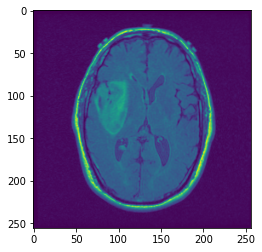

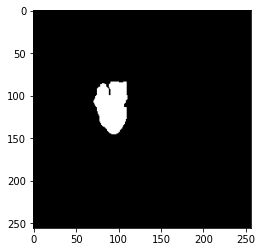

0.008067172


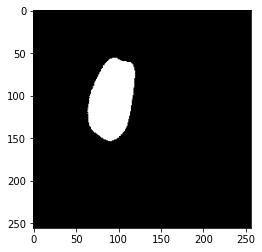

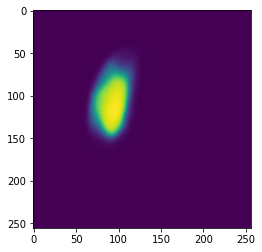

[0]


In [73]:
preds_train = model2.predict(X_test[:int(X_train.shape[0]*0.9)], verbose=1)
preds_train_t = (preds_train >0.1
).astype(np.uint8)
# idx = 130
idx = 210


plt.imshow(images[3300+idx])
plt.show()

tmp2 = masks[3300+idx]
plt.imshow(np.dstack((tmp2,tmp2,tmp2)))
plt.show()

print(np.mean(preds_train))
tmp = np.squeeze(preds_train_t[idx]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
# np.mean(preds_train[idx])
tmp3 = preds_train[idx]
# print(np.mean(tmp3))
# plt.imshow(np.dstack((tmp3,tmp3,tmp3)))
plt.imshow(tmp3.reshape(256,256))
plt.show()
print(preds_train_t[210][100][125])

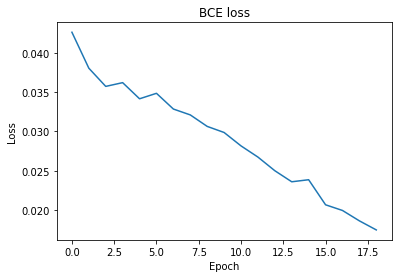

In [62]:
plt.plot(r2.history['loss'])
plt.title('BCE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [74]:
print(miou(masks[3300:len(masks)],preds_train_t))

0.9384727567912602


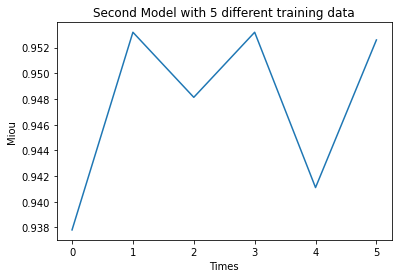

In [77]:
l = [0.9378,0.9532,0.94813,0.9532,0.9411,0.9526]

plt.plot(l)
plt.title('Second Model with 5 different training data')
plt.ylabel('Miou')
plt.xlabel('Times')
plt.show()

##### Third Model by using iou loss

###### Model

In [0]:
def iou_coef(y_true, y_pred):
  smooth = 1
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
  union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
  iou = (intersection + smooth) / ( union + smooth)
  return iou

def iou_coef_loss(y_true, y_pred):
  return 1-iou_coef(y_true, y_pred)

In [0]:
def third_model():
  start_neurons=16
  inputs = Input((256, 256,1))
  # s = Lambda(lambda x: x / 255) (inputs)

  # standard size 128 -> 64   custome size 101 -> 50
  conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(inputs)
  conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
  pool1 = MaxPooling2D((2, 2))(conv1)
  #pool1 = Dropout(0.25)(pool1)

  # standard size 64 -> 32       custome size 50 -> 25
  conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
  conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
  pool2 = MaxPooling2D((2, 2))(conv2)
  #pool2 = Dropout(0.25)(pool2)

  # standard size 32 -> 16       custome size 25 -> 12
  conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
  conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
  pool3 = MaxPooling2D((2, 2))(conv3)
  #pool3 = Dropout(0.25)(pool3)

  # standard size 16 -> 8       custome size 12 -> 6
  conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
  conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
  pool4 = MaxPooling2D((2, 2))(conv4)
  #pool4 = Dropout(0.25)(pool4)

  # Middle
  convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
  convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

  # standard size 8 -> 16         custome size 6-> 12
  deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
  uconv4 = concatenate([deconv4, conv4])
  #uconv4 = Dropout(0.25)(uconv4)
  uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
  uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

  # standard size 16 -> 32        custome size 12 -> 25
  # Changed padding from "same" to "valid" to round up image to next size
  #deconv3a = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
  deconv3 = Conv2DTranspose(start_neurons * 4, (2, 2), strides=(2, 2), padding="same")(uconv4)
  uconv3 = concatenate([deconv3, conv3])
  #uconv3 = Dropout(0.25)(uconv3)
  uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
  uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

  # standard size 32 -> 64   custome size 25 -> 50
  deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
  uconv2 = concatenate([deconv2, conv2])
  #uconv2 = Dropout(0.25)(uconv2)
  uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
  uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

  # standard size 64 -> 128   custome size 50 -> 101
  # Changed padding from "same" to "valid" to round up image to next size
  #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
  deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
  uconv1 = concatenate([deconv1, conv1])
  #uconv1 = Dropout(0.25)(uconv1)
  uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
  uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

  #uconv1 = Dropout(0.25)(uconv1)
  output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
  model = Model(inputs=[inputs], outputs=[output_layer])
  model.compile(optimizer=Adam(lr=1e-6), loss=iou_coef_loss, metrics=[iou_coef])
  model.summary()
  return model

###### Training

In [96]:
from keras.callbacks import EarlyStopping
train_generator = get_augmented(X_train,Y_train)

model3 = third_model()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('cse676_3.h5', verbose=1, save_best_only=True)
r3 = model3.fit_generator(train_generator,steps_per_epoch=100,epochs=15,callbacks=[earlystopper, checkpointer])

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 256, 256, 16) 160         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, 256, 256, 16) 2320        conv2d_115[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 128, 128, 16) 0           conv2d_116[0][0]                 
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,iou_coef
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


100/100 [==============================] - 23s 234ms/step - loss: 0.3310 - iou_coef: 0.6690
Epoch 3/15
100/100 [==============================] - 23s 234ms/step - loss: 0.3308 - iou_coef: 0.6692
Epoch 4/15
100/100 [==============================] - 24s 235ms/step - loss: 0.3307 - iou_coef: 0.6693
Epoch 5/15
100/100 [==============================] - 24s 238ms/step - loss: 0.3304 - iou_coef: 0.6696
Epoch 6/15
100/100 [==============================] - 24s 237ms/step - loss: 0.3303 - iou_coef: 0.6697
Epoch 7/15
100/100 [==============================] - 24s 235ms/step - loss: 0.3300 - iou_coef: 0.6700
Epoch 8/15
100/100 [==============================] - 24s 239ms/step - loss: 0.3298 - iou_coef: 0.6702
Epoch 9/15
100/100 [==============================] - 24s 238ms/step - loss: 0.3295 - iou_coef: 0.6705
Epoch 10/15
100/100 [==============================] - 24s 238ms/step - loss: 0.3292 - iou_coef: 0.6707
Epoch 11/15
100/100 [==============================] - 24s 237ms/step - loss: 0.328

###### Result Predict Graph

629/629 [==============================] - 1s 2ms/step


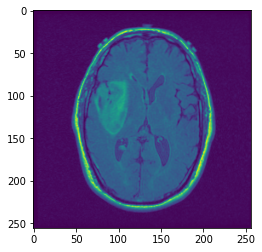

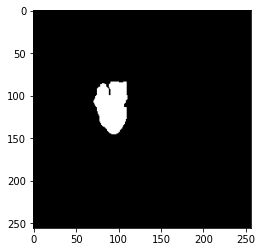

0.47809863


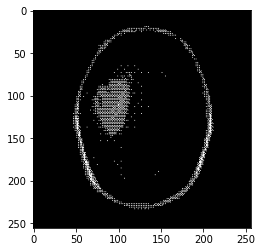

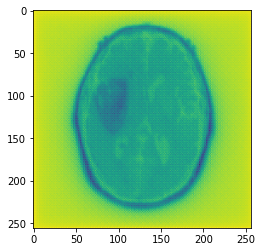

[0]


In [109]:
preds_train = model3.predict(X_test[:int(X_train.shape[0]*0.9)], verbose=1)
# preds_train_t = (preds_train <0.23
# ).astype(np.uint8)
preds_train_t = (preds_train <0.44
).astype(np.uint8)
# idx = 130
idx = 210


plt.imshow(images[3300+idx])
plt.show()

tmp2 = masks[3300+idx]
plt.imshow(np.dstack((tmp2,tmp2,tmp2)))
plt.show()

print(np.mean(preds_train))
tmp = np.squeeze(preds_train_t[idx]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
# np.mean(preds_train[idx])
tmp3 = preds_train[idx]
# print(np.mean(tmp3))
# plt.imshow(np.dstack((tmp3,tmp3,tmp3)))
plt.imshow(tmp3.reshape(256,256))
plt.show()
print(preds_train_t[210][100][125])

In [110]:
print(miou(masks[3300:len(masks)],preds_train_t))

0.8299101285035774


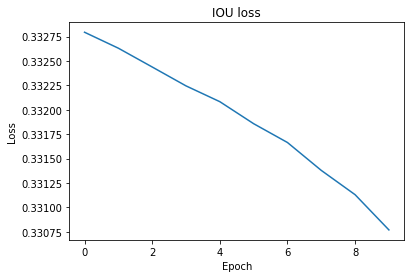

In [283]:
plt.plot(r3.history['loss'])
plt.title('IOU loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

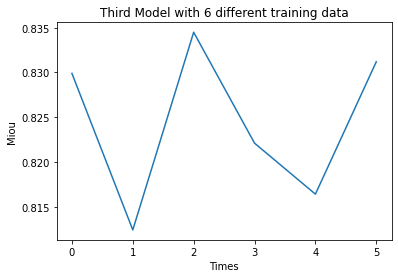

In [113]:
l = [0.8299,0.8124,0.8345,0.8221,0.8164,0.8312]

plt.plot(l)
plt.title('Third Model with 6 different training data')
plt.ylabel('Miou')
plt.xlabel('Times')
plt.show()

##### Fourth Model by using tversky_loss

###### Model

In [0]:
def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)
def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

In [0]:
kinit = 'glorot_normal'
def UnetConv2D(input, outdim, is_batchnorm, name):
	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_1')(input)
	if is_batchnorm:
		x =BatchNormalization(name=name + '_1_bn')(x)
	x = Activation('relu',name=name + '_1_act')(x)

	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_2')(x)
	if is_batchnorm:
		x = BatchNormalization(name=name + '_2_bn')(x)
	x = Activation('relu', name=name + '_2_act')(x)
	return x

def model():
  start_neurons=16
  inputs = Input((256, 256,1))
  s = Lambda(lambda x: x / 255) (inputs)

  # standard size 128 -> 64   custome size 101 -> 50
  conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(s)
  conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
  pool1 = MaxPooling2D((2, 2))(conv1)
  #pool1 = Dropout(0.25)(pool1)

  # standard size 64 -> 32       custome size 50 -> 25
  conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
  conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
  pool2 = MaxPooling2D((2, 2))(conv2)
  #pool2 = Dropout(0.25)(pool2)

  # standard size 32 -> 16       custome size 25 -> 12
  conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
  conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
  pool3 = MaxPooling2D((2, 2))(conv3)
  #pool3 = Dropout(0.25)(pool3)

  # standard size 16 -> 8       custome size 12 -> 6
  conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
  conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
  pool4 = MaxPooling2D((2, 2))(conv4)
  #pool4 = Dropout(0.25)(pool4)

  # Middle
  convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
  convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

  # standard size 8 -> 16         custome size 6-> 12
  deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
  uconv4 = concatenate([deconv4, conv4])
  #uconv4 = Dropout(0.25)(uconv4)
  uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
  uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

  # standard size 16 -> 32        custome size 12 -> 25
  # Changed padding from "same" to "valid" to round up image to next size
  #deconv3a = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
  deconv3 = Conv2DTranspose(start_neurons * 4, (2, 2), strides=(2, 2), padding="same")(uconv4)
  uconv3 = concatenate([deconv3, conv3])
  #uconv3 = Dropout(0.25)(uconv3)
  uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
  uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

  # standard size 32 -> 64   custome size 25 -> 50
  deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
  uconv2 = concatenate([deconv2, conv2])
  #uconv2 = Dropout(0.25)(uconv2)
  uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
  uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

  # standard size 64 -> 128   custome size 50 -> 101
  # Changed padding from "same" to "valid" to round up image to next size
  #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
  deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
  uconv1 = concatenate([deconv1, conv1])
  #uconv1 = Dropout(0.25)(uconv1)
  uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
  uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

  #uconv1 = Dropout(0.25)(uconv1)
  output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
  model = Model(inputs=[inputs], outputs=[output_layer])

  # model.compile(optimizer=Adam(lr=5e-7), loss= tversky_loss, metrics=[dsc])
  model.compile(optimizer=Adam(lr=1e-6), loss= tversky_loss, metrics=[focal_tversky])
  return model


###### Training

In [151]:
from keras.callbacks import EarlyStopping
train_generator = get_augmented(X_train,Y_train)

model4 = model()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('cse676_4.h5', verbose=1, save_best_only=True)
r4 = model4.fit_generator(train_generator,steps_per_epoch=100,epochs=20,callbacks=[earlystopper, checkpointer])

Epoch 1/20
100/100 [==============================] - 25s 251ms/step - loss: 0.9669 - focal_tversky: 0.9751
Epoch 2/20


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,focal_tversky
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


100/100 [==============================] - 24s 243ms/step - loss: 0.9672 - focal_tversky: 0.9753
Epoch 3/20
100/100 [==============================] - 24s 243ms/step - loss: 0.9662 - focal_tversky: 0.9745
Epoch 4/20
100/100 [==============================] - 24s 245ms/step - loss: 0.9675 - focal_tversky: 0.9755
Epoch 5/20
100/100 [==============================] - 24s 244ms/step - loss: 0.9660 - focal_tversky: 0.9744
Epoch 6/20
100/100 [==============================] - 25s 246ms/step - loss: 0.9684 - focal_tversky: 0.9762
Epoch 7/20
100/100 [==============================] - 25s 246ms/step - loss: 0.9660 - focal_tversky: 0.9744
Epoch 8/20
100/100 [==============================] - 25s 246ms/step - loss: 0.9675 - focal_tversky: 0.9755
Epoch 9/20
100/100 [==============================] - 25s 246ms/step - loss: 0.9671 - focal_tversky: 0.9752
Epoch 10/20
100/100 [==============================] - 24s 243ms/step - loss: 0.9668 - focal_tversky: 0.9750
Epoch 11/20
100/100 [=================

###### Result Predict Graph

629/629 [==============================] - 1s 2ms/step


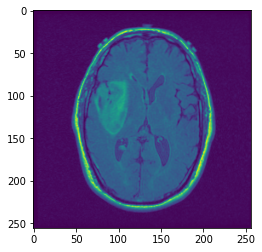

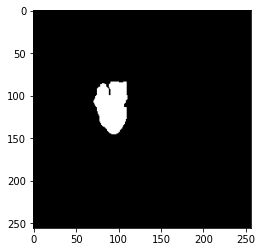

0.5003653


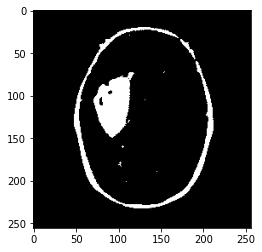

0.5004077


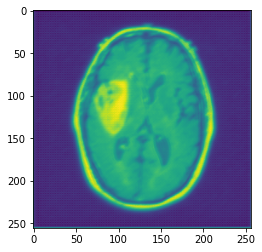

[0.5004456]


In [132]:
preds_train = model4.predict(X_test[:int(X_train.shape[0]*0.9)], verbose=1)
# preds_train_t = (preds_train <0.23
# ).astype(np.uint8)
preds_train_t = (preds_train >0.5006
).astype(np.uint8)
# idx = 130
idx = 210

plt.imshow(images[3300+idx])
plt.show()

tmp2 = masks[3300+idx]
plt.imshow(np.dstack((tmp2,tmp2,tmp2)))
plt.show()

print(np.mean(preds_train))
tmp = np.squeeze(preds_train_t[idx]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
np.mean(preds_train[idx])
tmp3 = preds_train[idx]
print(np.mean(tmp3))
# plt.imshow(np.dstack((tmp3,tmp3,tmp3)))
plt.imshow(tmp3.reshape(256,256))
plt.show()
print(preds_train[idx][75][75])

In [133]:
print(miou(masks[3300:len(masks)],preds_train_t))

0.8519523397454059


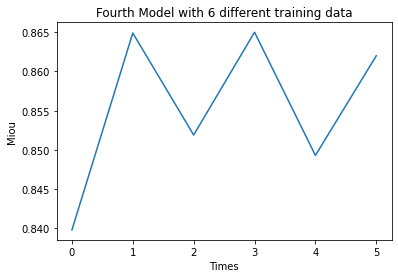

In [139]:
l = [0.8398,0.8649,0.8519,0.8650,0.8493,0.8620]

plt.plot(l)
plt.title('Fourth Model with 6 different training data')
plt.ylabel('Miou')
plt.xlabel('Times')
plt.show()

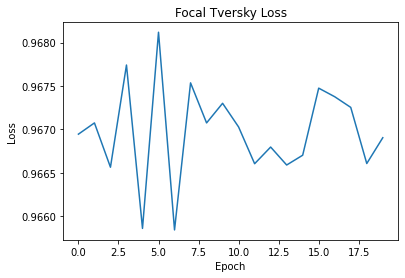

In [147]:
plt.plot(r4.history['loss'])
plt.title('Focal Tversky Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

##### Fifth Model by using dsc loss with avergepooling

###### Model

In [0]:
def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + 5) / (K.sum(y_true_f) + K.sum(y_pred_f) + 5)
 
 
def dice_coef_loss(y_true, y_pred):
  return 1. -dice_coef(y_true, y_pred)


In [0]:
def fifth_model():
  start_neurons=16
  inputs = Input((256, 256,1))
  # s = Lambda(lambda x: x / 255) (inputs)

  # standard size 128 -> 64   custome size 101 -> 50
  conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(inputs)
  conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
  pool1 = AveragePooling2D((2, 2))(conv1)
  #pool1 = Dropout(0.25)(pool1)

  # standard size 64 -> 32       custome size 50 -> 25
  conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
  conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
  pool2 =  MaxPooling2D((2, 2))(conv2)
  #pool2 = Dropout(0.25)(pool2)

  # standard size 32 -> 16       custome size 25 -> 12
  conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
  conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
  pool3 =  MaxPooling2D((2, 2))(conv3)
  #pool3 = Dropout(0.25)(pool3)

  # standard size 16 -> 8       custome size 12 -> 6
  conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
  conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
  pool4 =  MaxPooling2D((2, 2))(conv4)
  #pool4 = Dropout(0.25)(pool4)



  # Middle
  convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
  convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)


  # standard size 8 -> 16         custome size 6-> 12
  deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
  uconv4 = concatenate([deconv4, conv4])
  #uconv4 = Dropout(0.25)(uconv4)
  uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
  uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

  # standard size 16 -> 32        custome size 12 -> 25
  # Changed padding from "same" to "valid" to round up image to next size
  #deconv3a = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
  deconv3 = Conv2DTranspose(start_neurons * 4, (2, 2), strides=(2, 2), padding="same")(uconv4)
  uconv3 = concatenate([deconv3, conv3])
  #uconv3 = Dropout(0.25)(uconv3)
  uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
  uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

  # standard size 32 -> 64   custome size 25 -> 50
  deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
  uconv2 = concatenate([deconv2, conv2])
  #uconv2 = Dropout(0.25)(uconv2)
  uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
  uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

  # standard size 64 -> 128   custome size 50 -> 101
  # Changed padding from "same" to "valid" to round up image to next size
  #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
  deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
  uconv1 = concatenate([deconv1, conv1])
  #uconv1 = Dropout(0.25)(uconv1)
  uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
  uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

  #uconv1 = Dropout(0.25)(uconv1)
  output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
  model = Model(inputs=[inputs], outputs=[output_layer])
  model.compile(optimizer=Adam(lr=3e-7), loss=dice_coef_loss, metrics=[dice_coef])
  model.summary()
  return model

###### Training

In [81]:
from keras.callbacks import EarlyStopping
train_generator = get_augmented(X_train,Y_train)

model5 = fifth_model()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('cse676_5.h5', verbose=1, save_best_only=True)
r5 = model5.fit_generator(train_generator,steps_per_epoch=100,epochs=50,callbacks=[earlystopper, checkpointer])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 256, 256, 16) 160         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_77[0][0]                  
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 128, 128, 16) 0           conv2d_78[0][0]                  
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,dice_coef
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


100/100 [==============================] - 24s 240ms/step - loss: 0.9798 - dice_coef: 0.0202
Epoch 3/50
100/100 [==============================] - 24s 243ms/step - loss: 0.9791 - dice_coef: 0.0209
Epoch 4/50
100/100 [==============================] - 24s 239ms/step - loss: 0.9799 - dice_coef: 0.0201
Epoch 5/50
100/100 [==============================] - 24s 241ms/step - loss: 0.9790 - dice_coef: 0.0210
Epoch 6/50
100/100 [==============================] - 24s 240ms/step - loss: 0.9805 - dice_coef: 0.0195
Epoch 7/50
100/100 [==============================] - 24s 240ms/step - loss: 0.9790 - dice_coef: 0.0210
Epoch 8/50
100/100 [==============================] - 24s 240ms/step - loss: 0.9799 - dice_coef: 0.0201
Epoch 9/50
100/100 [==============================] - 24s 239ms/step - loss: 0.9797 - dice_coef: 0.0203
Epoch 10/50
100/100 [==============================] - 24s 239ms/step - loss: 0.9794 - dice_coef: 0.0206
Epoch 11/50
100/100 [==============================] - 24s 238ms/step - lo

###### Result Predict Graph

629/629 [==============================] - 1s 2ms/step


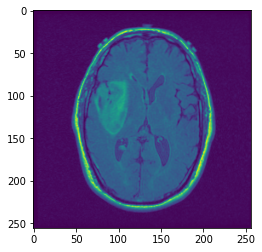

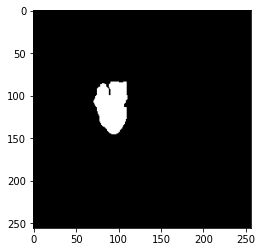

0.4991619


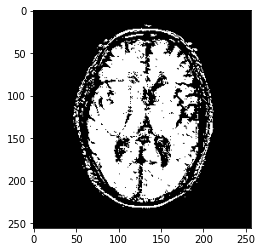

0.49932978


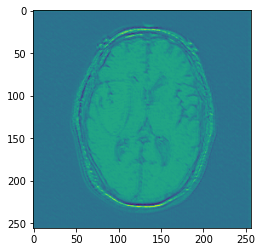

[0.49904928]


In [90]:
preds_train = model5.predict(X_test[:int(X_train.shape[0]*0.9)], verbose=1)
# preds_train_t = (preds_train <0.23
# ).astype(np.uint8)
preds_train_t = (preds_train >0.5
).astype(np.uint8)
# idx = 130
idx = 210

plt.imshow(images[3300+idx])
plt.show()

tmp2 = masks[3300+idx]
plt.imshow(np.dstack((tmp2,tmp2,tmp2)))
plt.show()

print(np.mean(preds_train))
tmp = np.squeeze(preds_train_t[idx]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
np.mean(preds_train[idx])
tmp3 = preds_train[idx]
print(np.mean(tmp3))
# plt.imshow(np.dstack((tmp3,tmp3,tmp3)))
plt.imshow(tmp3.reshape(256,256))
plt.show()
print(preds_train[idx][75][75])